In [1]:
!pip install torch_snippets
from torch_snippets import inspect, show, np, torch, nn
from torchvision.models import resnet50
model = resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model = model.eval()
import requests
from PIL import Image
url = 'https://lionsvalley.co.za/wp-content/uploads/2015/11/african-elephant-square.jpg'
original_image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
original_image = np.array(original_image)
original_image = torch.Tensor(original_image)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.9/172.9 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 110.5 MB/s eta 0:0

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]


In [2]:
image_net_classes = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
image_net_classes = requests.get(image_net_classes).text
image_net_ids = eval(image_net_classes)
image_net_classes = {i:j for j,i in image_net_ids.items()}

In [3]:
from torchvision import transforms as T
from torch.nn import functional as F
normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalize = T.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])
def image2tensor(input):
    x = normalize(input.clone().permute(2,0,1)/255.)[None]
    return x
def tensor2image(input):
    x = (denormalize(input[0].clone()).permute(1,2,0)*255.).type(torch.uint8)
    return x

In [4]:
def predict_on_image(input):
    model.eval()
    show(input)
    input = image2tensor(input)
    pred = model(input)
    pred = F.softmax(pred, dim=-1)[0]
    prob, clss = torch.max(pred, 0)
    clss = image_net_ids[clss.item()]
    print(f'PREDICTION: `{clss}` @ {prob.item()}')

In [5]:
from tqdm import trange
losses = []
def attack(image, model, target, epsilon=1e-6):
    input = image2tensor(image)
    input.requires_grad = True
    pred = model(input)
    loss = nn.CrossEntropyLoss()(pred, target)
    loss.backward()
    losses.append(loss.mean().item())
    output = input - epsilon * input.grad.sign()
    output = tensor2image(output)
    del input
    return output.detach()

In [6]:
modified_images = []
desired_targets = ['lemon', 'comic book', 'sax, saxophone']

In [7]:
for target in desired_targets:
    target = torch.tensor([image_net_classes[target]])
    image_to_attack = original_image.clone()
    for _ in trange(10):
        image_to_attack = attack(image_to_attack, model, target)
    modified_images.append(image_to_attack)

100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


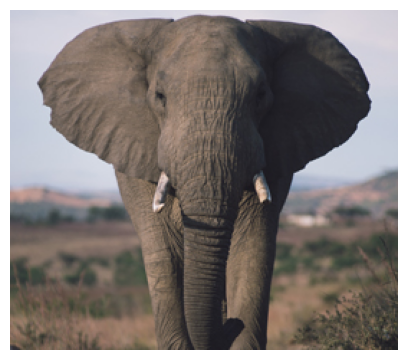

PREDICTION: `African elephant, Loxodonta africana` @ 0.5234402418136597


══════════════════════════════════════════════════════════════════

tensor([[[200., 203., 218.],
         [200., 203., 218.],
         [200., 203., 218.],
         ...,
         [207., 204., 215.],
         [207., 204., 215.],
         [207., 204., 215.]],

        [[199., 202., 217.],
         [200., 203., 218.],
         [200., 203., 218.],
         ...,
         [207., 204., 215.],
         [207., 204., 215.],
         [207., 204., 215.]],

        [[200., 203., 218.],
         [200., 203., 218.],
         [200., 203., 218.],
         ...,
         [208., 205., 216.],
         [208., 205., 216.],
         [208., 205., 216.]],

        ...,

        [[ 73.,  71.,  74.],
         [ 58.,  56.,  61.],
         [ 58.,  54.,  53.],
         ...,
         [ 34.,  32.,  37.],
         [ 35.,  33.,  38.],
         [ 38.,  39.,  43.]],

        [[ 76.,  73.,  82.],
         [ 57.,  54.,  63.],
         [ 49.,  47.,  50.],
         ...,
         [ 35.,  33.,  36.],
         [ 33.,  33.,  35.],
         [ 36.,  37.,  39.]],

        [[ 80.,  81.,  86.],
         [ 61.,  60.,  68.],
         [ 51.,  49.,  54.],
         ...,
         [ 37.,  35.,  38.],
         [ 33.,  33.,  35.],
         [ 35.,  36.,  38.]]])

══════════════════════════════════════════════════════════════════

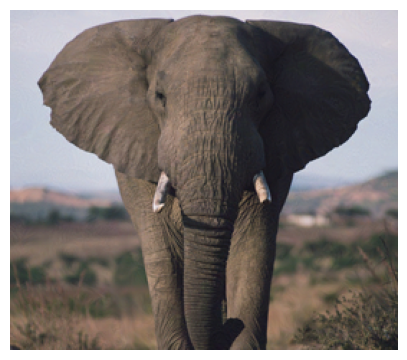

PREDICTION: `lemon` @ 0.9999924898147583


══════════════════════════════════════════════════════════════════

tensor([[[194, 199, 213],
         [196, 199, 214],
         [194, 197, 211],
         ...,
         [201, 198, 209],
         [200, 197, 209],
         [200, 198, 207]],

        [[196, 199, 212],
         [195, 199, 213],
         [196, 198, 211],
         ...,
         [200, 199, 208],
         [199, 198, 209],
         [198, 195, 208]],

        [[197, 199, 213],
         [194, 197, 215],
         [196, 199, 213],
         ...,
         [203, 203, 211],
         [200, 199, 210],
         [199, 198, 207]],

        ...,

        [[ 71,  66,  66],
         [ 54,  51,  53],
         [ 54,  50,  46],
         ...,
         [ 27,  27,  35],
         [ 26,  28,  32],
         [ 34,  34,  39]],

        [[ 74,  67,  74],
         [ 50,  45,  55],
         [ 42,  39,  41],
         ...,
         [ 28,  29,  33],
         [ 24,  27,  31],
         [ 28,  30,  32]],

        [[ 79,  78,  78],
         [ 59,  56,  60],
         [ 45,  41,  50],
         ...,
         [ 30,  28,  29],
         [ 25,  25,  26],
         [ 28,  29,  33]]], dtype=torch.uint8)

══════════════════════════════════════════════════════════════════

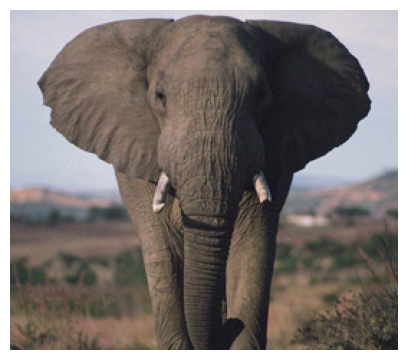

PREDICTION: `comic book` @ 0.9999731779098511


══════════════════════════════════════════════════════════════════

tensor([[[195, 196, 212],
         [198, 196, 213],
         [199, 198, 216],
         ...,
         [203, 197, 208],
         [203, 200, 209],
         [201, 199, 210]],

        [[198, 200, 214],
         [197, 198, 215],
         [197, 197, 210],
         ...,
         [203, 196, 207],
         [205, 199, 210],
         [205, 200, 211]],

        [[196, 200, 218],
         [198, 197, 213],
         [196, 197, 210],
         ...,
         [202, 197, 210],
         [204, 199, 211],
         [204, 198, 210]],

        ...,

        [[ 63,  64,  73],
         [ 48,  48,  57],
         [ 53,  53,  52],
         ...,
         [ 27,  28,  30],
         [ 30,  29,  31],
         [ 36,  37,  41]],

        [[ 67,  71,  81],
         [ 50,  50,  62],
         [ 39,  41,  47],
         ...,
         [ 30,  27,  29],
         [ 26,  27,  27],
         [ 33,  34,  36]],

        [[ 75,  80,  85],
         [ 52,  57,  66],
         [ 42,  42,  51],
         ...,
         [ 34,  30,  32],
         [ 26,  25,  27],
         [ 29,  30,  31]]], dtype=torch.uint8)

══════════════════════════════════════════════════════════════════

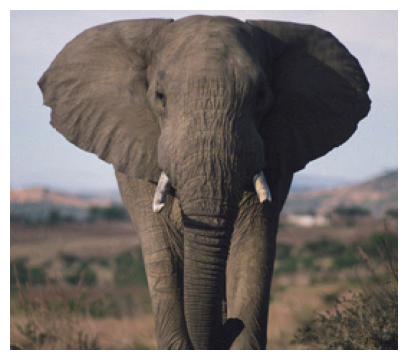

PREDICTION: `sax, saxophone` @ 0.9999992847442627


══════════════════════════════════════════════════════════════════

tensor([[[198, 200, 214],
         [198, 197, 211],
         [197, 197, 212],
         ...,
         [201, 197, 207],
         [199, 196, 209],
         [199, 197, 207]],

        [[197, 197, 210],
         [200, 198, 212],
         [198, 197, 211],
         ...,
         [204, 199, 207],
         [201, 200, 211],
         [201, 200, 213]],

        [[194, 195, 209],
         [197, 196, 211],
         [197, 196, 210],
         ...,
         [205, 200, 210],
         [205, 197, 209],
         [199, 197, 210]],

        ...,

        [[ 69,  70,  70],
         [ 53,  50,  56],
         [ 51,  47,  47],
         ...,
         [ 28,  23,  30],
         [ 30,  26,  33],
         [ 31,  32,  35]],

        [[ 73,  68,  76],
         [ 48,  48,  57],
         [ 40,  40,  42],
         ...,
         [ 31,  29,  32],
         [ 29,  27,  30],
         [ 31,  31,  32]],

        [[ 77,  79,  81],
         [ 54,  56,  63],
         [ 44,  44,  51],
         ...,
         [ 33,  31,  35],
         [ 31,  30,  32],
         [ 31,  32,  35]]], dtype=torch.uint8)

══════════════════════════════════════════════════════════════════

In [8]:
for image in [original_image, *modified_images]:
    predict_on_image(image)
    inspect(image)

---